In [16]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [17]:
import torch
from avicortex.datasets import OpenNeuroCannabisUsersDataset
from torch_geometric.loader import DataLoader

In [18]:
tr_dataset = OpenNeuroCannabisUsersDataset(
    "left",
    freesurfer_out_path="../datasets/openneuro_baseline_dktatlas.csv",
    mode="train",
    src_view_idx=0,
    tgt_view_idx=2,
)
tr_dataloader = DataLoader(tr_dataset, batch_size=5)
g_source, g_target = next(iter(tr_dataloader))

Hem:lh, Edges found: (34, 34, 42, 5)
Hem:lh, Nodes found: (34, 42, 5)
Hem:lh, Edges found: (34, 34, 42, 5)
Hem:lh, Nodes found: (34, 42, 5)


/tmp/ipykernel_21032/2936835883.py:1: DeprecationWarning: freesurfer_out_path is deprecated, use src_atlas_path and tgt_atlas_path instead.
  tr_dataset = OpenNeuroCannabisUsersDataset(


In [19]:
from grenolnet.model import SinusoidalPositionEmbeddings

TIMESTEP = 5
net = SinusoidalPositionEmbeddings(6)
input_time = torch.ones(1).to("cuda") * TIMESTEP
print(input_time)
learned_embed = net(input_time)
learned_embed

tensor([5.], device='cuda:0')


tensor([[-9.5892e-01,  4.9979e-02,  5.0000e-04,  2.8366e-01,  9.9875e-01,
          1.0000e+00]], device='cuda:0')

/tmp/ipykernel_21032/3398005920.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


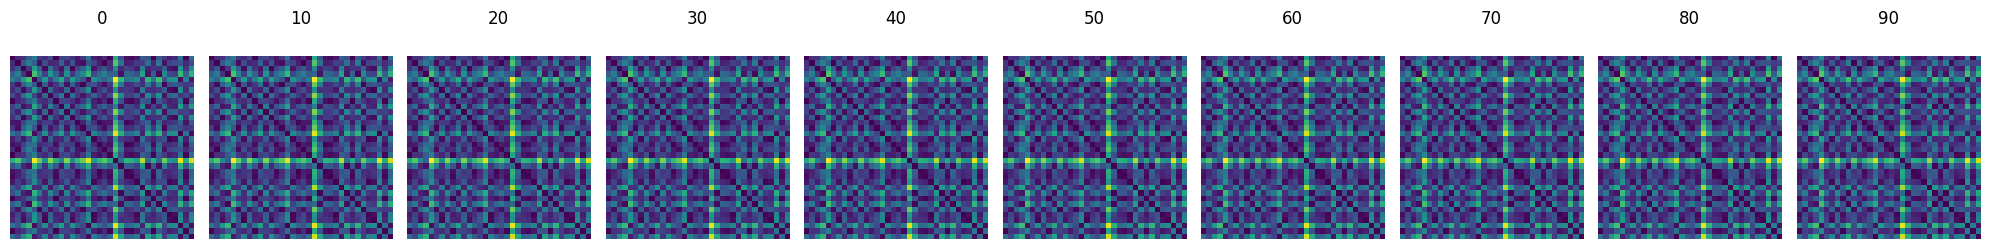

In [20]:
from grenolnet.diffusion import GraphDiffusion
from grenolnet.model import GrenolNet
from grenolnet.plotting import plot_graph_adjacency

diffuser = GraphDiffusion(
    step_count=100,
    noise_schedule="linear",
    noise_dist="normal",
    noise_mean=0.0,
    noise_std=0.01,
    noise_max=0.02,
)

model = GrenolNet(1, 1, 34, 48).to(device="cuda")
model.load_state_dict(
    torch.load(
        "../models/cs_left_500epochs_5folds_batchnorm/cs_left_500epochs_5folds_batchnorm_fold0.pth"
    )
)

TIMESTEP = 99
noisy_graphs, added_noise = diffuser.forward_add_noise_to_batch(g_target)
plot_graph_adjacency(noisy_graphs[::10], list(range(0, 100, 10)), figsize=20)
timesteps = torch.randint(
    0, diffuser.step_count, (g_target.x.shape[0],), device="cuda"
).long()
pred_noise = model.forward(noisy_graphs[TIMESTEP], g_source, timesteps)

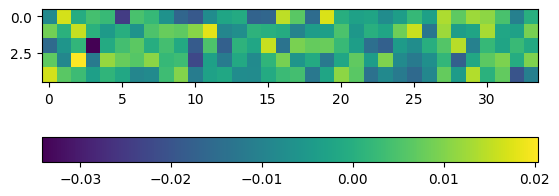

In [21]:
import matplotlib.pyplot as plt

plt.imshow(added_noise.cpu().detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

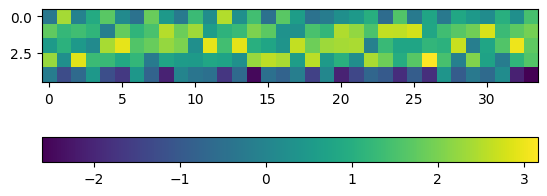

In [22]:
TIMESTEP = 99
pred_noise = model.forward(noisy_graphs[TIMESTEP], g_source, timesteps)
plt.imshow(pred_noise.squeeze().cpu().detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

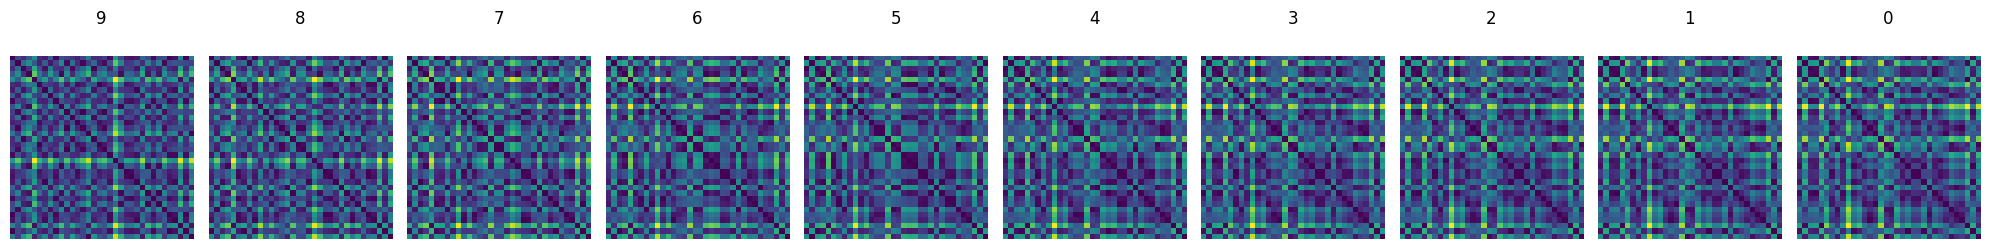

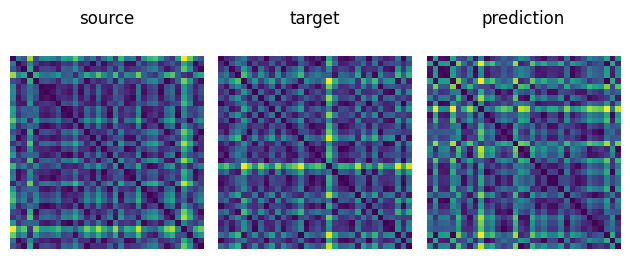

Frobenius loss between target and prediction: 8.356101036071777


In [23]:
from grenolnet.plotting import plot_graph_adjacency
from torch_geometric.data import Data as PygData

g_source_sample = g_source.to_data_list()[0]
noise = diffuser.create_noise_like(g_source_sample.x)
noisy_edge_attr = diffuser.calculate_edges(noise.squeeze(0))
edge_index = diffuser.create_edge_connectivity(len(noise.squeeze()))
full_noise_graph = PygData(
    x=noise,
    edge_index=edge_index,
    edge_attr=noisy_edge_attr.unsqueeze(0),
)
# noisy_graphs, applied_noise = test_diffuser.forward_add_noise(gaussian1)
# denoised_graphs = diffuser.forward_remove_noise(
#     model,
#     full_noise_graph,
#     source_graph=g_source_sample,
#     noise=noise,
# )
SAMPLE_IDX_IN_BATCH = 0
denoised_graphs = diffuser.forward_remove_noise(
    added_noise[0:1], noisy_graphs[-1].to_data_list()[0], noise=added_noise[0:1]
)
# denoised_graphs = diffuser.forward_remove_noise(
#     added_noise,
#     denoised_graphs[-1],
#     noise=added_noise
# )
plot_graph_adjacency(denoised_graphs[::10], list(range(10))[::-1], figsize=20)
plot_graph_adjacency(
    [g_source_sample, g_target, denoised_graphs[-1]], ["source", "target", "prediction"]
)
frob = torch.sqrt(
    torch.square(denoised_graphs[-1].edge_attr - g_target.edge_attr).sum()
).mean()
print("Frobenius loss between target and prediction:", frob.item())